In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [116]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
titanic_path='/Users/cheriatahmed/Desktop/ach/1-Work/Titanic.csv'
df = sqlContext.read.format('com.databricks.spark.csv'
                           ).options(header='true', inferschema='true').load(titanic_path)

# Data cleaning
# Clean
df2 = df.where((df.PassengerId != 62) &  ((df.PassengerId != 836)))
print df2.count()
#Delete Rows having Blanck Ages
df_cleaned = df2.filter((df2.Survived.isNotNull()) & (df2.Pclass.isNotNull()) & 
                (df2.Sex.isNotNull()) & (df2.Age.isNotNull()) &
                (df2.SibSp.isNotNull()) & (df2.Parch.isNotNull()) &
                (df2.Embarked.isNotNull()) & (df2.Embarked != '') 
                )
print df_cleaned.count()


889
711


In [117]:
# Read the CSV file
data = df_cleaned.toPandas()#pd.read_csv('/Users/cheriatahmed/Desktop/ach/1-Work/Titanic.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,,S


In [118]:
#Nb rows of data
len(data)

711

In [119]:
data2 = data.filter(data['PassengerId'] != 62)
len(data2)

711

In [120]:
# List of unique classes
data['Survived'].unique()

array([0, 1])

In [121]:
len(data['Cabin'].unique())


133

In [122]:
# Number of entries for each unique classes
class_group = data.groupby(data["Survived"]).apply(lambda x : len(x))
class_group

Survived
0    424
1    287
dtype: int64

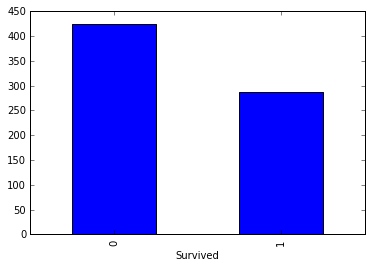

In [123]:
# Plot bar chart based on Class Label
class_group.plot(kind='bar', grid=False) #plot(kind='bar', grid=False)

In [124]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch','Embarked']
#DF ne comportant que les features
X_feature = data[features]
#Transforme les features en un dictionaire [{nom_feature1: valeur_feature1, ....}]
X_dict = X_feature.T.to_dict().values()

In [125]:
X_feature.head()

,Pclass,Sex,Age,SibSp,Parch,Embarked
0,3,male,22.0,1,0,S
1,1,female,38.0,1,0,C
2,3,female,26.0,0,0,S
3,1,female,35.0,1,0,S
4,3,male,35.0,0,0,S


In [126]:
X_dict[1:3]

[{'Age': 38.0,
  'Embarked': u'C',
  'Parch': 0,
  'Pclass': 1,
  'Sex': u'female',
  'SibSp': 1},
 {'Age': 26.0,
  'Embarked': u'S',
  'Parch': 0,
  'Pclass': 3,
  'Sex': u'female',
  'SibSp': 0}]

In [127]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer

# Transformer la list de dictionaires X_dict en une matrice numpy
vect = DictVectorizer(sparse=False)
X_vector = vect.fit_transform(X_dict)

In [128]:
# print the features
vect.get_feature_names()

['Age',
 u'Embarked=C',
 u'Embarked=Q',
 u'Embarked=S',
 'Parch',
 'Pclass',
 u'Sex=female',
 u'Sex=male',
 'SibSp']

In [129]:
X_vector[0]

array([ 22.,   0.,   0.,   1.,   0.,   3.,   0.,   1.,   1.])

3
-178 rows having empty Embarked value


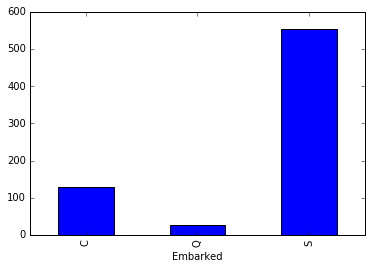

In [130]:
#Pourquoi existe -t-il une colonne Embarked sans valeur ? 
print len(data['Embarked'].unique())
embark_group = data.groupby(data["Embarked"]).apply(lambda x : len(x))
embark_group.plot(kind='bar', grid=False)
embark_group

print len(data) - (168 + 77 + 644), "rows having empty Embarked value"

In [131]:
# data Train, Data test
X_Train = X_vector[:-600]
X_Test = X_vector[-600:] 
print len(X_Train), len(X_Test)

111 600


In [132]:
X_Train[1:3]

array([[ 38.,   1.,   0.,   0.,   0.,   1.,   1.,   0.,   1.],
       [ 26.,   0.,   0.,   1.,   0.,   3.,   1.,   0.,   0.]])

In [133]:
# Used to vectorize the class label
le = LabelEncoder()
y_train = le.fit_transform(data['Survived'][:-600])
len(y_train)

111

In [134]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(criterion='entropy')
clf = clf.fit(X_Train,y_train)

In [137]:
# Predict the test data, not seen earlier
X_Test1 = X_vector[120]
print X_Test1
vect.get_feature_names()

[ 51.   0.   0.   1.   0.   2.   0.   1.   0.]


['Age',
 u'Embarked=C',
 u'Embarked=Q',
 u'Embarked=S',
 'Parch',
 'Pclass',
 u'Sex=female',
 u'Sex=male',
 'SibSp']

In [138]:
pred = clf.predict(X_Test1)
print pred
label_inverse = le.inverse_transform(pred)
print label_inverse

[0]
[0]


/Users/cheriatahmed/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


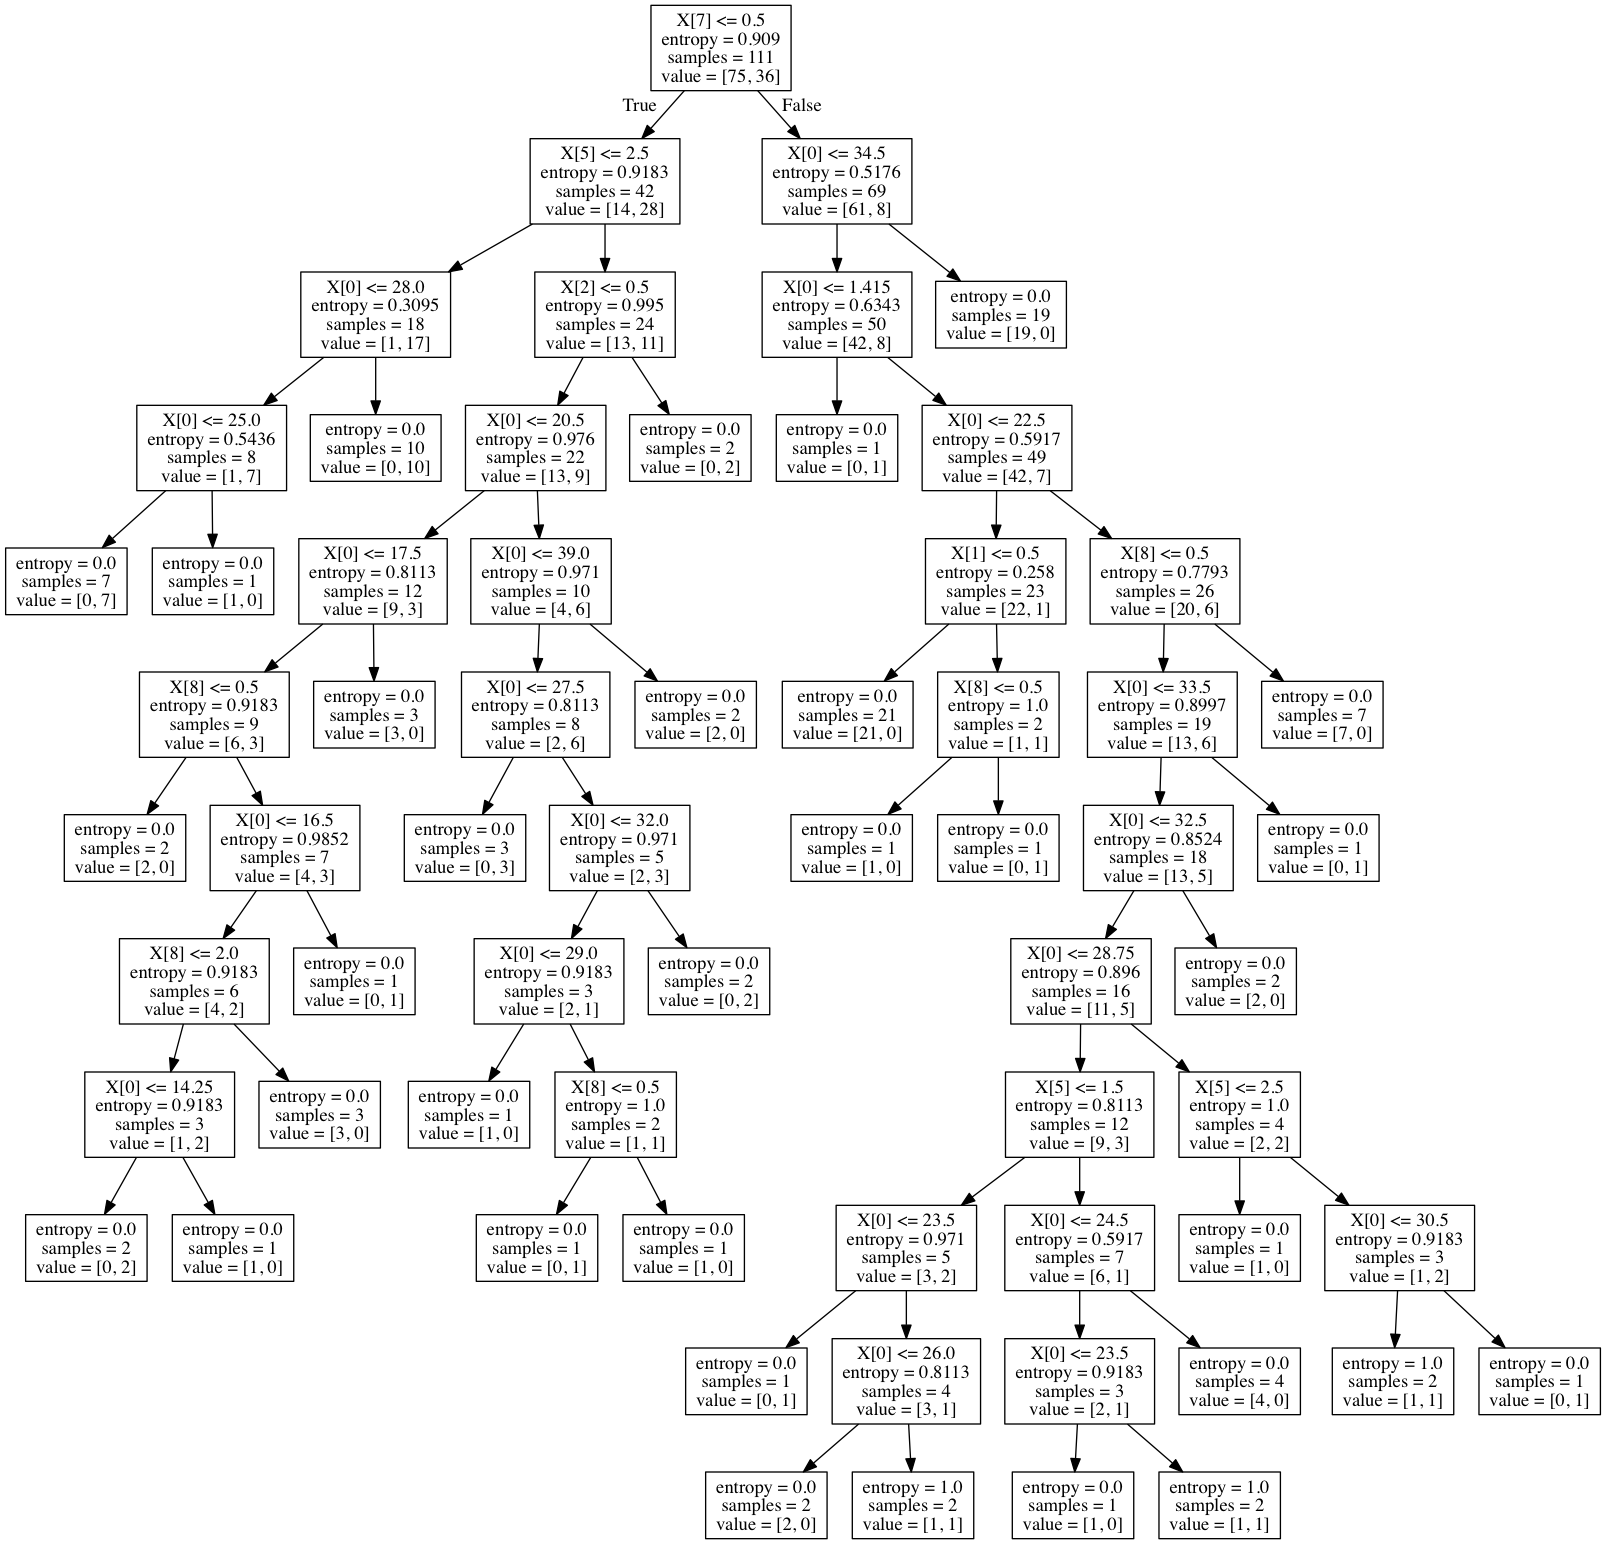

In [139]:
import pydot
import pydotplus

import StringIO
dot_data = StringIO.StringIO() 
tree.export_graphviz(clf, out_file=dot_data) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph.write_png('/Users/cheriatahmed/Desktop/ach/temp/tree.png') 
from IPython.core.display import Image 
Image(filename='/Users/cheriatahmed/Desktop/ach/temp/tree.png')

In [142]:
import pandas as pd

s = pd.Series([0.5, 2])
print True in (s > 1)
print (s > 1).all()

True
False


## Decision tree with Sckikit learn

In [144]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,,S


In [146]:
from sklearn import tree
from sklearn import preprocessing

In [149]:
import numpy as np
import pandas as pd
import os

In [162]:
# Initialize label encoder
label_encoder = preprocessing.LabelEncoder()

# Convert Sex variable to numeric
encoded_sex = label_encoder.fit_transform(data["Sex"])

# Initialize model
tree_model = tree.DecisionTreeClassifier(criterion='entropy')

# Train the model
X = pd.DataFrame(encoded_sex)
Y = data["Survived"]
titanic_tree_model = tree_model.fit(X, Y)

In [163]:
import pydot
import pydotplus

import StringIO
dot_data = StringIO.StringIO() 
tree.export_graphviz(titanic_tree_model, feature_names=["Sex"], out_file=dot_data) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph.write_png('/Users/cheriatahmed/Desktop/ach/temp/tree1.png') 

True

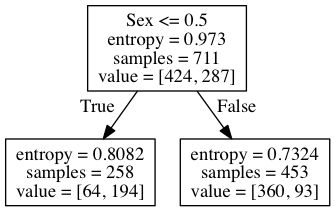

In [164]:
from IPython.core.display import Image 
Image(filename='/Users/cheriatahmed/Desktop/ach/temp/tree1.png')